# Proyecto final Image Recognition
## Álvaro Andrés Esquivel Gómez - 11002822
## Video explicativo: https://drive.google.com/file/d/124Z6KUWlBJ5oQVg4rPObBngNmgYDM710/view?usp=sharing

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#Funcion para leer imagenes
def verImagen(dir_imagen):
    image2 = cv2.imread(dir_imagen, cv2.IMREAD_COLOR)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(image2)

### Imagen inicial

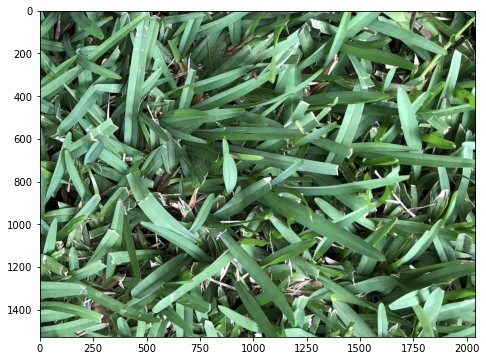

In [3]:
verImagen("imagen1.jpg")

### Estrategia
La estrategia para la resolución de este problema es hacer uso de técnicas de segmentación para con la finalidad de separar los tallos del suelo y entre sí mismos, y luego segmentar los tallos en componentes contables para brindar un estimado de la cantidad de tallos en una imagen. 

Para ello se utilizaron diversos algoritmos de procesamiento de imágenes con la librería especializada OpenCV, la descripción de la funcionalidad de cada comando utilizado esta descrito de forma de comentarios en cada línea importante durante el proceso de transformación de la imagen y el conteo final de elementos.

In [20]:
def estimado_cant_grama(dir_imagen):
    
    img = cv2.imread(dir_imagen)
    print("Tamaño de la imagen: ", img.shape)
    
    #Transformacion de la imagen a blanco y negro
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Muestra la transformacion de la imagen a escala de grises
    plt.figure(figsize=(8,6))
    plt.title('Transformación a escala de grises', fontsize=20)
    plt.imshow(gris, cmap='gray')
    plt.show()
    
    ## 1. Separación entre el suelo y los tallos
    #Binarizacion de la imagen, utilizando metodo de Otsu (utilizado para obtener el umbral)
    #Si el valor de píxel es menor que el umbral, se establece en 0 de lo contrario, se establece en 255. 
    #El algoritmo de Otsu devuelve un único umbral de intensidad que separa los píxeles en dos clases, 
    #   primer plano y fondo. Este umbral se determina minimizando la variación de intensidad dentro de la clase o, 
    #   de manera equivalente, maximizando la variación entre clases.
    #THRESH_BINARY_INV es parametro de binarizacion 
    cont, binarizacion = cv2.threshold(gris,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    #Se revierte la binarizacion para considear los tallos de grama como la parte de maxima intensidad
    binarizacion = 255 - binarizacion
        
    #Muestra la binarizacion de la imagen
    plt.figure(figsize=(8,6))
    plt.title('Binarización a de la imagen', fontsize=20)
    plt.imshow(binarizacion, cmap='gray')
    plt.show()

    ## 2. Quitar el ruido de la imagen
    #Creacion de Kernel de 3x3 para remover ruido de la imagen
    #uint8: tipo Numpy utilizado para imagenes entre 0 y 255
    kernel = np.ones((3,3), np.uint8)
    #Se utiliza transformaciones morfologicas para el procesamiento basadas en formas (identificar los tallos)
    #Utilizando parametro MORPH_OPEN para evitar porciones muy pequeñas de pixeles
    morfo_res = cv2.morphologyEx(binarizacion, cv2.MORPH_OPEN, kernel, iterations = 2)
    
    ## 3. Identificar los tallos
    #La transformación morfologica es dilatada, para aumentar el area de los tallos y acentuar características
    suelo = cv2.dilate(morfo_res, kernel, iterations=3)
    
    ## 4. Identificar el suelo
    #Encuentra el área del primer plano de la imagen, relativo al fondo
    #distanceTransform: Calcula la distancia al píxel cero más cercano para cada píxel de la imagen de origen.
    #DIST_L2: utilizando la distancia euclidiana
    dist_transform = cv2.distanceTransform(morfo_res, cv2.DIST_L2, 5)
    
    #Aplica de nuevo una binarizacion entre la distancia de los pixeles calculada anteriormente
    #Con la finalidad de separar mejor los tallos de suelo
    cont, tallos_iden = cv2.threshold(dist_transform, 0.7*dist_transform.max(),255,0)
    
    #Transformacion de formato para asegurar las unidades
    tallos_iden = np.uint8(tallos_iden)
    
    #Diferencia entre los tallos y el suelo
    bin_completa = suelo - tallos_iden
    
    #Muestra la binarizacion de la imagen
    plt.figure(figsize=(8,6))
    plt.title('Separación completa de tallos y suelo', fontsize=20)
    plt.imshow(bin_completa, cmap='gray')
    plt.show()
    
    ## 5. Conteo de tallos
    #Calcula los componentes conectados imagen etiquetada de la imagen booleana
    #Retorna la cantidad de componentes (espacios completos de maxima intensidad rodeados de baja intensidad)
    #Los componentes son la representacion binaria de los tallos de grama
    #Labels son grupos de componentes por pixel, 0 es el suelo
    cont, labels = cv2.connectedComponents(bin_completa)
    
    #Creacion de matizes de colores para etiquetas
    colores_etiquetas = np.uint8(180 * labels / np.max(labels))
    
    tono_oscuro = 255 * np.ones_like(colores_etiquetas)
    
    #Crear una nueva imagen con las etiquetas identificadas coloreadas
    #Unifica los colores de la matriz en una matriz de 3 canales de tipo HSV (matiz, saturacion, brillo)
    img_colores = cv2.merge([colores_etiquetas, tono_oscuro, tono_oscuro])
    #Transformacion de HSV a BGR
    img_colores = cv2.cvtColor(img_colores, cv2.COLOR_HSV2BGR)
    #Convirtiendo fondo color negro
    img_colores[colores_etiquetas == 0] = 0

    #Muestra imagen con etiquetas colerada y con el numero del conteo
    plt.figure(figsize=(8,6))
    plt.title('Conteo de tallos:'+ str(cont), fontsize=20)
    plt.imshow(img_colores)
    plt.show()

    return cont


Tamaño de la imagen:  (1528, 2038, 3)


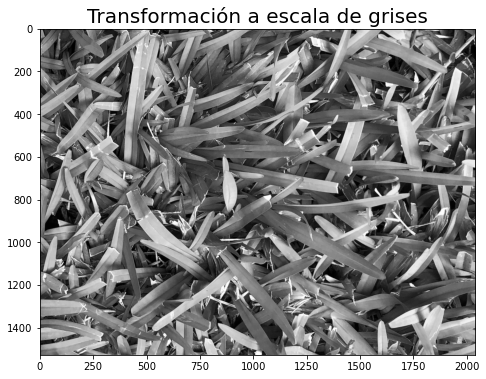

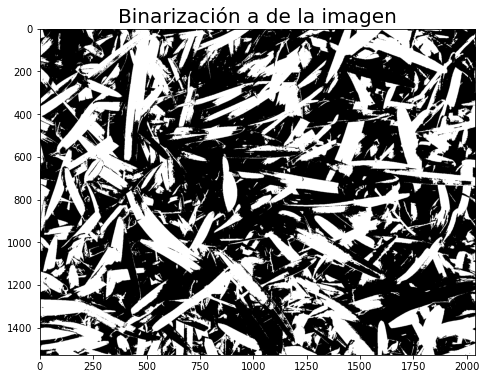

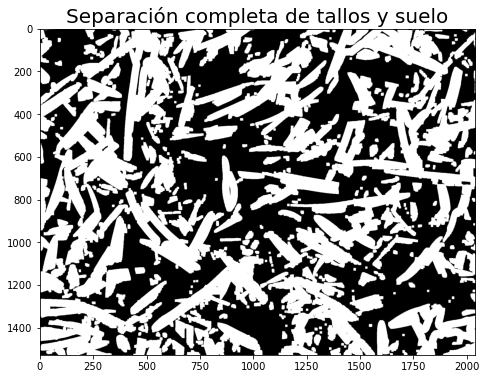

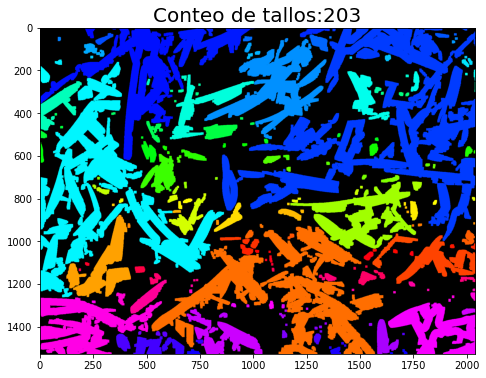

In [22]:
num_tallos = estimado_cant_grama("imagen1.jpg")

## Plano del jardín

![title](plano_jardin.jpg)

Para calcular la cantidad de tallos de grama de mi jardín, es necesario calcular el área de este, así como considerar el área calculada por la fotografía de la grama mostrada en los algoritmos. Para ello, y con la ayuda de los planos de mi casa. La imagen de los tallos de grama representa una superficie en 16 x 12 cm en la realidad, por lo que es necesario obtener el área de esa superficie y luego dividirla por el área del jardín, para luego multiplicar por la cantidad de tallos, con la finalidad de obtener el número total de tallos de grama en mi jardín. Es importante añadir que aproximadamente el 80% de la superficie esta cubierta.

In [50]:
area_jardin_mt2 = round(2.5 * 4.99, 4)
print("Área total del jardín: ", area_jardin_mt2)

#La imagen representaba unas dimenciones de 16 * 12 cm
area_grama_mt2 = round(0.16 * 0.12, 4)
print("Área total de la grama en la imagen: ", area_grama_mt2)

cant_tallos_jardin = ((area_jardin_mt2 / area_grama_mt2) * num_tallos) * 0.8
print("Cantidad aproximada de tallos en el jardín: ", int(cant_tallos_jardin))

Área total del jardín:  12.475
Área total de la grama en la imagen:  0.0192
Cantidad aproximada de tallos en el jardín:  105517


![title](imagen_jardin.jpg)

## Cantidad de tallos de grama en un campo de golf

![title](augusta_golf_club.jpg)

La imagen superior pertenece uno de los campos de golf más famoso del mundo, el Augusta National Golf Club, ubicando en Estados Unidos. Según la información obtenida el campo de golf tiene aproximadamente 140 hectáreas (al ser un campo completo), y en su mayoría está cubierto de grama. 

Esas 140 hectáreas, deben de ser convertidas a metros cuadrados y multiplicado por la cantidad de grama encontrada en la fotografía, suponiendo que el campo de golf tendría una densidad aproximadamente similar, y considerando que el campo está compuesto en un 75% grama.

In [48]:
area_golf_mt2 = 140 * 10000
print("Área total del campo de golf: ", area_golf_mt2)

cant_tallos_golf = ((area_golf_mt2 / area_grama_mt2) * num_tallos) * 0.75
print("Cantidad aproximada de tallos en el el campo de golf: ", int(cant_tallos_golf))

Área total del campo de golf:  1400000
Cantidad aproximada de tallos en el el campo de golf:  11101562500
